> GNAR fiveNet,fivenodes lag 1

# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

# torch
import torch
import torch.nn.functional as F
import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU

# scipy 
from scipy.interpolate import interp1d

# utils
import copy
import time
import pickle
import itertools
from tqdm import tqdm

# rpy2
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri as rpyn

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# pre-defined

In [3]:
def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

In [4]:
def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

In [5]:
def plot(f,*args,t=None,h=2.5,**kwargs):
    T,N = f.shape
    if t is None: t = range(T)
    fig = plt.figure()
    ax = fig.subplots(N,1)
    for n in range(N):
        ax[n].plot(t,f[:,n],*args,**kwargs)
        ax[n].set_title('node='+str(n))
    fig.set_figheight(N*h)
    fig.tight_layout()
    plt.close()
    return fig

In [6]:
def plot_add(fig,f,*args,t=None,**kwargs):
    T = f.shape[0]
    N = f.shape[1] 
    if t is None: t = range(T)   
    ax = fig.get_axes()
    for n in range(N):
        ax[n].plot(t,f[:,n],*args,**kwargs)
    return fig

In [7]:
def make_Psi(T):
    W = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                W[i,j] = 1
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi

In [8]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [9]:
def trim(f):
    f = np.array(f)
    if len(f.shape)==1: f = f.reshape(-1,1)
    T,N = f.shape
    Psi = make_Psi(T)
    fbar = Psi.T @ f # apply dft 
    fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar[:,i])) for i in range(N)],axis=1)
    fhat = Psi @ fbar_threshed # inverse dft 
    return fhat

In [10]:
def update_from_freq_domain(signal, missing_index):
    signal = np.array(signal)
    T,N = signal.shape 
    signal_trimed = trim(signal)
    for i in range(N):
        signal[missing_index[i],i] = signal_trimed[missing_index[i],i]
    return signal

In [11]:
class DatasetLoader(object):
    def __init__(self,data_dict):
        self._dataset = data_dict 

    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["FX"])
        self.features = [
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
        self.targets = [
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]

    def get_dataset(self, lags: int = 4) -> torch_geometric_temporal.signal.StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(torch_geometric_temporal.signal.StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = torch_geometric_temporal.signal.StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset

In [12]:
def _convert_train_dataset(train_dataset):
    lags = torch.tensor(train_dataset.features).shape[-1]
    f = torch.concat([train_dataset[0].x.T,torch.tensor(train_dataset.targets)],axis=0).numpy()
    return f,lags 

In [13]:
def miss_rand(train_dataset,missing_ratio=0.5):
    f,lags = _convert_train_dataset(train_dataset)
    T,N = f.shape
    missing_count = int(np.round(missing_ratio*T,0))
    mindex = [np.sort(np.random.choice(range(T),missing_count,replace=False)).tolist() for i in range(N)]  
    for i,m in enumerate(mindex): 
        f[m,i] = np.nan
    data_dict = {
        'edges':train_dataset.edge_index.T.tolist(), 
        'node_ids':{'node'+str(i):i for i in range(N)}, 
        'FX':f.tolist()
    }
    train_dataset = DatasetLoader(data_dict).get_dataset(lags=lags)
    train_dataset.mindex = mindex
    train_dataset.mrate_eachnode = [len(mx)/T for mx in mindex]
    train_dataset.mrate_total= float(np.sum([len(mx) for mx in train_dataset.mindex])/(N*T))
    train_dataset.mtype= 'rand'
    return  train_dataset

In [14]:
def padding(train_dataset_miss,*args,interpolation_method='linear',**kwargs):
    mindex = train_dataset_miss.mindex 
    f,lags = _convert_train_dataset(train_dataset_miss)
    T,N = f.shape
    FX = pd.DataFrame(f).interpolate(method=interpolation_method,axis=0,*args,**kwargs).fillna(method='bfill').fillna(method='ffill').to_numpy().tolist()
    data_dict = {
        'edges':train_dataset_miss.edge_index.T.tolist(), 
        'node_ids':{'node'+str(i):i for i in range(N)}, 
        'FX':FX
    }
    train_dataset_padded = DatasetLoader(data_dict).get_dataset(lags=lags)
    train_dataset_padded.mindex = mindex
    train_dataset_padded.mrate_eachnode = train_dataset_miss.mrate_eachnode
    train_dataset_padded.mrate_total = train_dataset_miss.mrate_total
    train_dataset_padded.mtype= train_dataset_miss.mtype
    train_dataset_padded.interpolation_method = interpolation_method
    return train_dataset_padded

In [15]:
class StgcnLearner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.mindex= getattr(self.train_dataset,'mindex',None)
        self.mrate_eachnode = getattr(self.train_dataset,'mrate_eachnode',0)
        self.mrate_total = getattr(self.train_dataset,'mrate_total',0)
        self.mtype = getattr(self.train_dataset,'mtype',None)
        self.interpolation_method = getattr(self.train_dataset,'interpolation_method',None)
        self.method = 'STGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.model.train()
        for e in range(epoch):
            for t, snapshot in enumerate(self.train_dataset):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat-snapshot.y)**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        self.epochs = epoch+1
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

In [16]:
class Evaluator:
    def __init__(self,learner,train_dataset,test_dataset):
        self.learner = learner
        self.learner.model.eval()
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.lags = lrnr.lags
        rslt_tr = self.learner(self.train_dataset) 
        rslt_test = self.learner(self.test_dataset)
        self.X_tr = rslt_tr['X']
        self.y_tr = rslt_tr['y']
        self.f_tr = torch.concat([self.train_dataset[0].x.T,self.y_tr],axis=0).float()
        self.yhat_tr = rslt_tr['yhat']
        self.fhat_tr = torch.concat([self.train_dataset[0].x.T,self.yhat_tr],axis=0).float()
        self.X_test = rslt_test['X']
        self.y_test = rslt_test['y']
        self.f_test = self.y_test 
        self.yhat_test = rslt_test['yhat']
        self.fhat_test = self.yhat_test
        self.f = torch.concat([self.f_tr,self.f_test],axis=0)
        self.fhat = torch.concat([self.fhat_tr,self.fhat_test],axis=0)
    def calculate_mse(self):
        test_base_mse_eachnode = ((self.y_test - self.y_test.mean(axis=0).reshape(-1,self.y_test.shape[-1]))**2).mean(axis=0).tolist()
        test_base_mse_total = ((self.y_test - self.y_test.mean(axis=0).reshape(-1,self.y_test.shape[-1]))**2).mean().item()
        train_mse_eachnode = ((self.y_tr-self.yhat_tr)**2).mean(axis=0).tolist()
        train_mse_total = ((self.y_tr-self.yhat_tr)**2).mean().item()
        test_mse_eachnode = ((self.y_test-self.yhat_test)**2).mean(axis=0).tolist()
        test_mse_total = ((self.y_test-self.yhat_test)**2).mean().item()
        self.mse = {'train': {'each_node': train_mse_eachnode, 'total': train_mse_total},
                    'test': {'each_node': test_mse_eachnode, 'total': test_mse_total},
                    'test(base)': {'each_node': test_base_mse_eachnode, 'total': test_base_mse_total},
                   }
    def _plot(self,*args,t=None,h=2.5,max_node=5,**kwargs):
        T,N = self.f.shape
        if t is None: t = range(T)
        fig = plt.figure()
        nof_axs = max(min(N,max_node),2)
        if min(N,max_node)<2: 
            print('max_node should be >=2')
        ax = fig.subplots(nof_axs ,1)
        for n in range(nof_axs):
            ax[n].plot(t,self.f[:,n],color='gray',*args,**kwargs)
            ax[n].set_title('node='+str(n))
        fig.set_figheight(nof_axs*h)
        fig.tight_layout()
        plt.close()
        return fig
    def plot(self,*args,t=None,h=2.5,**kwargs):
        self.calculate_mse()
        fig = self._plot(*args,t=None,h=2.5,**kwargs)
        ax = fig.get_axes()
        for i,a in enumerate(ax):
            _mse1= self.mse['train']['each_node'][i]
            _mse2= self.mse['test']['each_node'][i]
            _mse3= self.mse['test(base)']['each_node'][i]
            _mrate = lrnr.mrate_eachnode if set(dir(lrnr.mrate_eachnode)) & {'__getitem__'} == set() else lrnr.mrate_eachnode[i]
            _title = 'node{0}, mrate: {1:.2f}% \n mse(train) = {2:.2f}, mse(test) = {3:.2f}, mse(test_base) = {4:.2f}'.format(i,_mrate*100,_mse1,_mse2,_mse3)
            a.set_title(_title)
            _t1 = self.lags
            _t2 = self.yhat_tr.shape[0]+self.lags
            _t3 = len(self.f)
            a.plot(range(_t1,_t2),self.yhat_tr[:,i],label='fitted (train)',color='C0')
            a.plot(range(_t2,_t3),self.yhat_test[:,i],label='fitted (test)',color='C1')
            a.legend()
        _mse1= self.mse['train']['total']
        _mse2= self.mse['test']['total']
        _mse3= self.mse['test(base)']['total']
        _title =\
        'dataset: {0} \n method: {1} \n mrate: {2:.2f}% \n interpolation:{3} \n epochs={4} \n number of filters={5} \n lags = {6} \n mse(train) = {7:.2f}, mse(test) = {8:.2f}, mse(test_base) = {9:.2f} \n'.\
        format(lrnr.dataset_name,lrnr.method,lrnr.mrate_total*100,lrnr.interpolation_method,lrnr.epochs,lrnr.nof_filters,lrnr.lags,_mse1,_mse2,_mse3)
        fig.suptitle(_title)
        fig.tight_layout()
        return fig

In [17]:
class ITStgcnLearner(StgcnLearner):
    def __init__(self,train_dataset,dataset_name = None):
        super().__init__(train_dataset)
        self.method = 'IT-STGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.model.train()
        train_dataset_temp = copy.copy(self.train_dataset)
        for e in range(epoch):
            f,lags = _convert_train_dataset(train_dataset_temp)
            f = update_from_freq_domain(f,self.mindex)
            T,N = f.shape 
            data_dict_temp = {
                'edges':self.train_dataset.edge_index.T.tolist(), 
                'node_ids':{'node'+str(i):i for i in range(N)}, 
                'FX':f
            }
            train_dataset_temp = DatasetLoader(data_dict_temp).get_dataset(lags=self.lags)  
            for t, snapshot in enumerate(train_dataset_temp):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat-snapshot.y)**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # record
        self.nof_filters = filters
        self.epochs = epoch+1

In [18]:
class SimulationPlanner:
    def __init__(self,plans,loader,dataset_name=None,simulation_results=None):
        self.plans = plans
        col = ['dataset', 'method', 'mrate', 'mtype', 'lags', 'nof_filters', 'inter_method', 'epoch', 'mse']
        self.product_iterator = itertools.product(
            plans['method'], 
            plans['mrate'],
            plans['mtype'],
            plans['lags'],
            plans['nof_filters'],
            plans['inter_method'],
            plans['epoch']
        )
        self.loader = loader
        self.dataset_name = dataset_name
        self.simulation_results = pd.DataFrame(columns=col) if simulation_results is None else simulation_results 
    def _simulate_STGCN(self):
        for prod_itor in self.product_iterator:
            method,mrate,mtype,lags,nof_filters,inter_method,epoch = prod_itor 
            self.dataset = self.loader.get_dataset(lags=lags)
            train_dataset, test_dataset = torch_geometric_temporal.signal.temporal_signal_split(self.dataset, train_ratio=0.8)
            if mrate >0: 
                if mtype == 'rand':
                    train_dataset = padding(miss_rand(train_dataset,missing_ratio=mrate),interpolation_method=inter_method)
                elif mtype == 'block':
                    pass 
            lrnr = StgcnLearner(train_dataset,dataset_name=self.dataset_name)
            lrnr.learn(filters=nof_filters,epoch=epoch)
            evtor = Evaluator(lrnr,train_dataset,test_dataset)
            evtor.calculate_mse()
            mse = evtor.mse['test']['total']
            self._record(*prod_itor,mse)
    def _record(self,method,mrate,mtype,lag,nof_filter,inter_method,epoch,mse):
        dct = {'dataset': self.dataset_name,
               'method': method,
               'mrate': mrate,
               'mtype': mtype, 
               'lags': lag,
               'nof_filters': nof_filter,
               'inter_method': inter_method,
               'epoch': epoch,
               'mse': mse
              }
        simulation_result_new = pd.Series(dct).to_frame().transpose()
        self.simulation_results = pd.concat([self.simulation_results,simulation_result_new])

# From R 

In [19]:
%load_ext rpy2.ipython

In [20]:
%%R
library(GNAR)
library(igraph)
library(zoo)

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Loading required package: wordcloud

R[write to console]: Loading required package: RColorBrewer

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [21]:
%%R
fiveNet_m <- as.matrix(fiveNet)

In [22]:
%R -o fiveNet_m

In [23]:
GNAR = importr('GNAR') # import GNAR 
igraph = importr('igraph') # import igraph 

# 예제1: vanilla STGCN

`-` 데이터 

In [24]:
_data = load_data('./data/fivenodes.pkl')

In [27]:
_edges = torch.tensor(_data['edges']).nonzero().tolist()
_FX = _data['f'].tolist()
_node_ids = {'node1':0, 'node2':1, 'node3':2, 'node4':3, 'node5':4} 

In [28]:
data_dict = {'edges':_edges, 'node_ids':_node_ids, 'FX':_FX}

In [30]:
loader = DatasetLoader(data_dict)
dataset = loader.get_dataset(lags=2)
train_dataset, test_dataset = torch_geometric_temporal.signal.temporal_signal_split(dataset, train_ratio=0.8)

`-` 학습

In [32]:
lrnr = StgcnLearner(train_dataset,dataset_name='five_nodes')

In [33]:
lrnr.learn(filters=4,epoch=50)

`-` 적합값

In [36]:
# lrnr(train_dataset) 
# lrnr(test_dataset)

- 실행하면 X,y,yhat 출력 

`-` 모형 평가 및 시각화

---

***baseline***

In [37]:
torch.tensor(test_dataset.targets).shape

torch.Size([40, 5])

In [38]:
((torch.tensor(test_dataset.targets)- torch.tensor(test_dataset.targets).mean(axis=0).reshape(-1,5))**2).mean()

tensor(1.2525, dtype=torch.float64)

test MSE는 1.2525 보다는 무조건 낮아야함!! 아니라면 모형을 잘못 돌린거

---

In [39]:
evtor = Evaluator(lrnr,train_dataset,test_dataset)

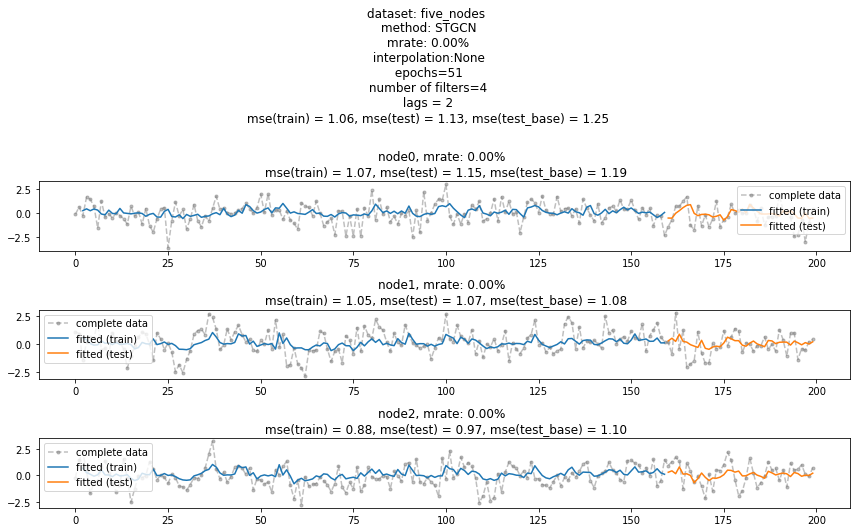

In [40]:
fig = evtor.plot('--.',h=5,max_node=3,label='complete data',alpha=0.5) 
fig.set_figwidth(12)
fig.tight_layout()
fig

# 예제2: padding missing values 

`-` 데이터 

In [41]:
# _data = load_data('./data/fivenodes.pkl')

# _edges = torch.tensor(_data['edges']).nonzero().tolist()
# _FX = _data['f'].tolist()
# _node_ids = {'node1':0, 'node2':1, 'node3':2, 'node4':3, 'node5':4} 

data_dict = {'edges':_edges, 'node_ids':_node_ids, 'FX':_FX}

In [42]:
loader = DatasetLoader(data_dict)
dataset = loader.get_dataset(lags=2)
train_dataset, test_dataset = torch_geometric_temporal.signal.temporal_signal_split(dataset, train_ratio=0.8)

`-` 임의로 결측치 발생 

In [43]:
train_dataset_miss = miss_rand(train_dataset,missing_ratio=0.5)

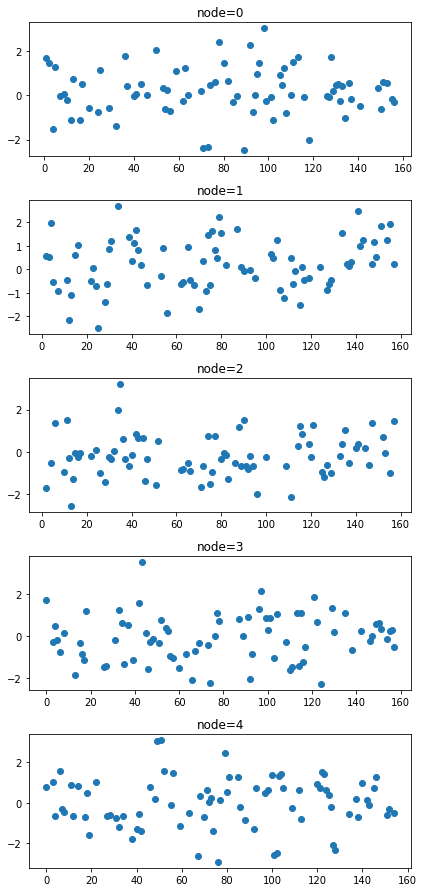

In [299]:
fig = plot(torch.tensor(train_dataset_miss.targets),'o')
fig 

`-` 적절한 method로 결측치를 채움 (default 는 linear)

In [300]:
train_dataset_padded = padding(train_dataset_miss) # padding(train_dataset_miss,method='linear'와 같음)

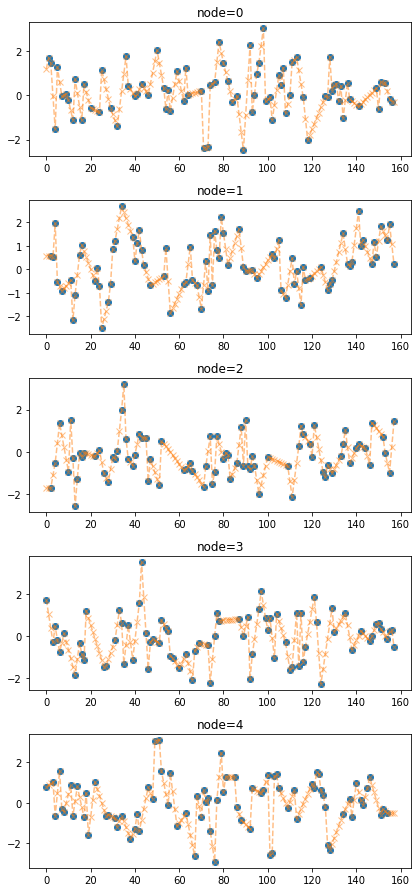

In [301]:
fig = plot(torch.tensor(train_dataset_miss.targets),'o')
plot_add(fig,torch.tensor(train_dataset_padded.targets),'--x',color='C1',alpha=0.5)

다른 method로 결측치를 채울수도 있음. 사용할 수 있는 방법들은 아래에 정리되어 있음 

- ref: <https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html>

In [302]:
train_dataset_padded2 = padding(train_dataset_miss,interpolation_method='nearest')

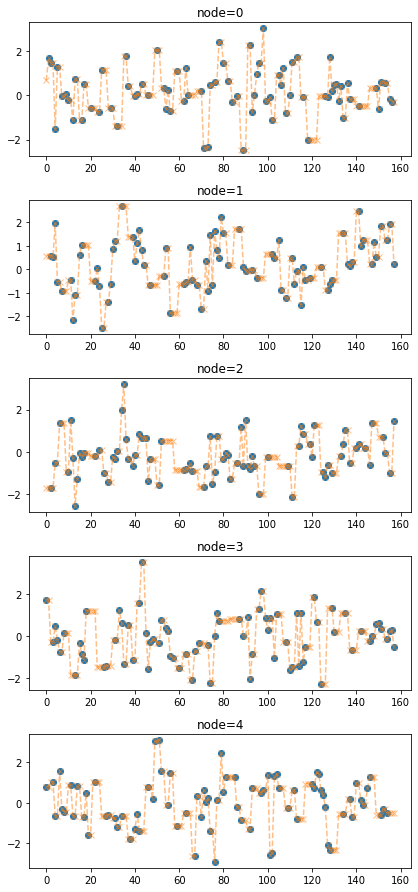

In [303]:
fig = plot(torch.tensor(train_dataset_miss.targets),'o')
plot_add(fig,torch.tensor(train_dataset_padded2.targets),'--x',color='C1',alpha=0.5)

In [304]:
train_dataset_padded3 = padding(train_dataset_miss,interpolation_method='quadratic')

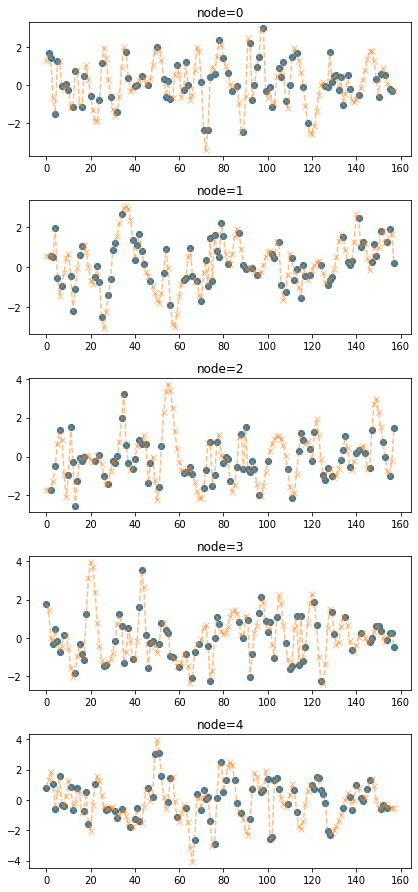

In [305]:
fig = plot(torch.tensor(train_dataset_miss.targets),'o')
plot_add(fig,torch.tensor(train_dataset_padded3.targets),'--x',color='C1',alpha=0.5)

In [306]:
train_dataset_padded4 = padding(train_dataset_miss,interpolation_method='cubic')

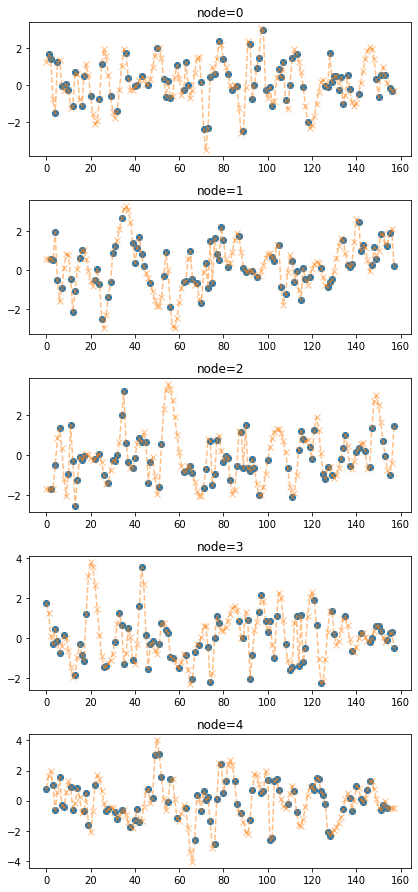

In [307]:
fig = plot(torch.tensor(train_dataset_miss.targets),'o')
plot_add(fig,torch.tensor(train_dataset_padded4.targets),'--x',color='C1',alpha=0.5)

# 예제3: vanilla STGCN with random missing 

`-` data

In [308]:
# _data = load_data('./data/fivenodes.pkl')

# _edges = torch.tensor(_data['edges']).nonzero().tolist()
# _FX = _data['f'].tolist()
# _node_ids = {'node1':0, 'node2':1, 'node3':2, 'node4':3, 'node5':4} 

data_dict = {'edges':_edges, 'node_ids':_node_ids, 'FX':_FX}

In [309]:
loader = DatasetLoader(data_dict)
dataset = loader.get_dataset(lags=2)
train_dataset, test_dataset = torch_geometric_temporal.signal.temporal_signal_split(dataset, train_ratio=0.8)

In [310]:
train_dataset_miss = miss_rand(train_dataset,missing_ratio=0.8)
train_dataset_padded = padding(train_dataset_miss) # padding(train_dataset_miss,method='linear'와 같음)

`-` 학습

In [311]:
lrnr = StgcnLearner(train_dataset_padded)

In [312]:
lrnr.learn(filters=4,epoch=50)

`-` 적합값

In [313]:
#lrnr(train_dataset_padded) 
#lrnr(test_dataset)

- 실행하면 X,y,yhat 출력 

`-` 모형 평가 및 시각화

In [314]:
evtor = Evaluator(lrnr,train_dataset_padded,test_dataset)

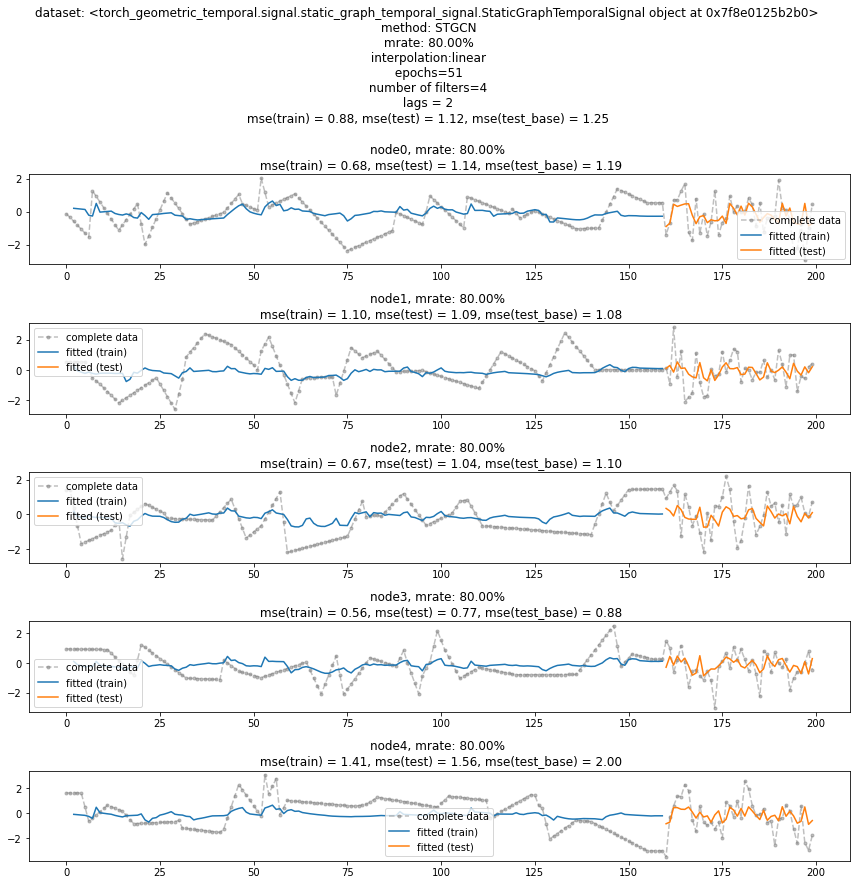

In [315]:
fig = evtor.plot('--.',h=5,max_node=5,label='complete data',alpha=0.5) # max_nodes 는 1보다 커야함
fig.set_figwidth(12)
fig.tight_layout()
fig

# 예제4: threshold example 

`-` data 

In [316]:
# _data = load_data('./data/fivenodes.pkl')

# _edges = torch.tensor(_data['edges']).nonzero().tolist()
# _FX = _data['f'].tolist()
# _node_ids = {'node1':0, 'node2':1, 'node3':2, 'node4':3, 'node5':4} 

data_dict = {'edges':_edges, 'node_ids':_node_ids, 'FX':_FX}

In [317]:
loader = DatasetLoader(data_dict)
dataset = loader.get_dataset(lags=2)
train_dataset, test_dataset = torch_geometric_temporal.signal.temporal_signal_split(dataset, train_ratio=0.8)

`-` 결측치 발생 및 패딩 

In [318]:
train_dataset_miss = miss_rand(train_dataset,missing_ratio=0.5)
train_dataset_padded = padding(train_dataset_miss)

In [319]:
f_miss,_ = _convert_train_dataset(train_dataset_miss)
f_padded,_ = _convert_train_dataset(train_dataset_padded)

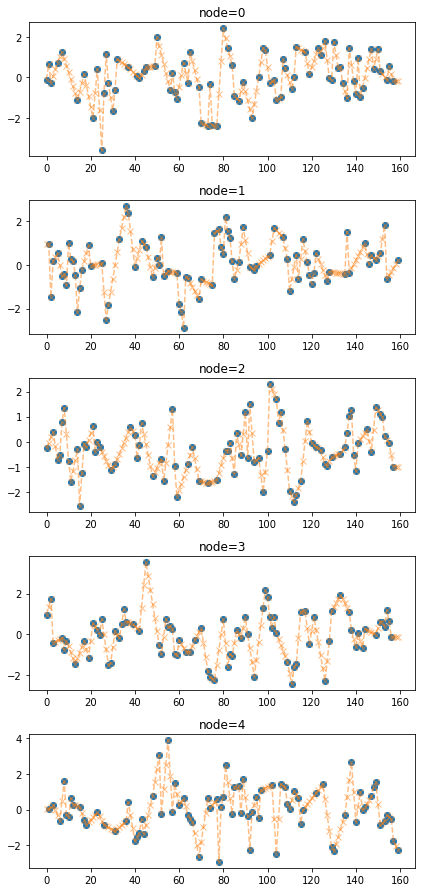

In [320]:
fig = plot(f_miss,'o')
plot_add(fig,f_padded,'--x',alpha=0.5)

`-` update by frequency thresholding

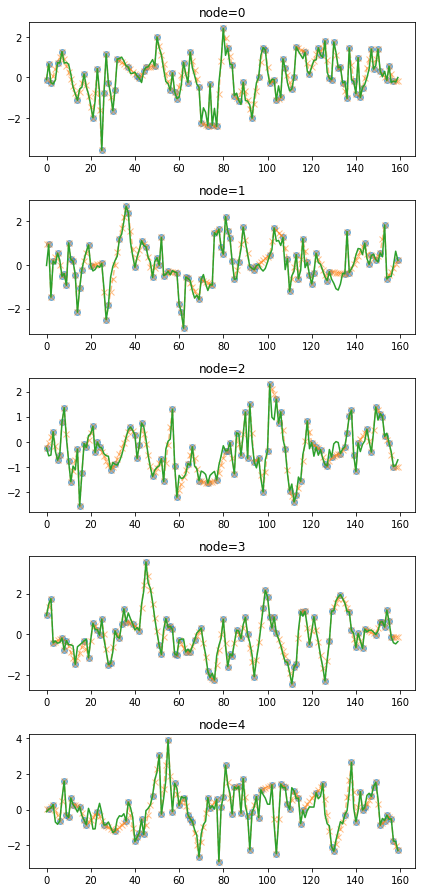

In [321]:
fig = plot(f_miss,'o',alpha=0.5)
plot_add(fig,f_padded,'--x',alpha=0.5)
f_updated = update_from_freq_domain(f_padded,train_dataset_padded.mindex)
plot_add(fig,f_updated,'-')

# 예제5: iterative thresholded STGCN (IT-STGCN) with random missing

`-` data

In [322]:
# _data = load_data('./data/fivenodes.pkl')

# _edges = torch.tensor(_data['edges']).nonzero().tolist()
# _FX = _data['f'].tolist()
# _node_ids = {'node1':0, 'node2':1, 'node3':2, 'node4':3, 'node5':4} 

data_dict = {'edges':_edges, 'node_ids':_node_ids, 'FX':_FX}

In [323]:
loader = DatasetLoader(data_dict)
dataset = loader.get_dataset(lags=2)
train_dataset, test_dataset = torch_geometric_temporal.signal.temporal_signal_split(dataset, train_ratio=0.8)

In [324]:
train_dataset_miss = miss_rand(train_dataset,missing_ratio=0.8)
train_dataset_padded = padding(train_dataset_miss) # padding(train_dataset_miss,method='linear'와 같음)

`-` 학습

In [325]:
lrnr = ITStgcnLearner(train_dataset_padded)

In [326]:
lrnr.learn(filters=4,epoch=50)

`-` 적합값

In [327]:
#lrnr(train_dataset_padded) 
#lrnr(test_dataset)

- 실행하면 X,y,yhat 출력 

`-` 모형 평가 및 시각화

In [328]:
evtor = Evaluator(lrnr,train_dataset_padded,test_dataset)

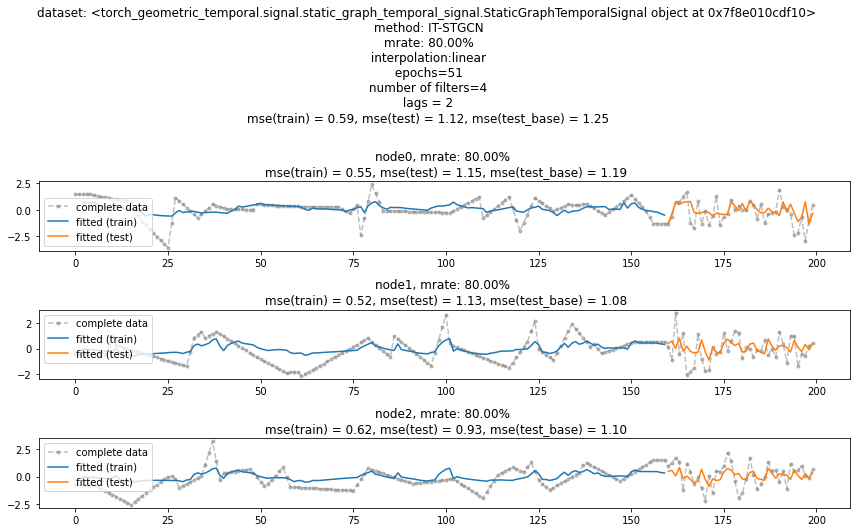

In [329]:
fig = evtor.plot('--.',h=5,max_node=3,label='complete data',alpha=0.5) # max_nodes 는 1보다 커야함
fig.set_figwidth(12)
fig.tight_layout()
fig

# 예제6: GNAR 

# 예제7: SimulationPlanner 

In [330]:
# _data = load_data('./data/fivenodes.pkl')

# _edges = torch.tensor(_data['edges']).nonzero().tolist()
# _FX = _data['f'].tolist()
# _node_ids = {'node1':0, 'node2':1, 'node3':2, 'node4':3, 'node5':4} 

data_dict = {'edges':_edges, 'node_ids':_node_ids, 'FX':_FX}

In [56]:
loader = DatasetLoader(data_dict)

In [65]:
plans = {
    'max_iteration': [2], 
    'method':['STGCN','IT-STGCN'], 
    'mrate':[0.0, 0.2], 
    'mtype':['rand'], 
    'lags':[4,8], 
    'nof_filters':[16,24], 
    'inter_method':['nearest','linear'],
    'epoch': [3]
}

In [66]:
planner = SimulationPlanner(plans,loader,dataset_name='five_nodes')

In [67]:
planner._simulate_STGCN()

In [69]:
planner.simulation_results.reset_index()

,index,dataset,method,mrate,mtype,lags,nof_filters,inter_method,epoch,mse
0,0,five_nodes,STGCN,0.0,rand,4,16,nearest,3,1.173286
1,0,five_nodes,STGCN,0.0,rand,4,16,linear,3,1.186759
2,0,five_nodes,STGCN,0.0,rand,4,24,nearest,3,1.15008
3,0,five_nodes,STGCN,0.0,rand,4,24,linear,3,1.165545
4,0,five_nodes,STGCN,0.0,rand,8,16,nearest,3,1.138814
5,0,five_nodes,STGCN,0.0,rand,8,16,linear,3,1.155973
6,0,five_nodes,STGCN,0.0,rand,8,24,nearest,3,1.136766
7,0,five_nodes,STGCN,0.0,rand,8,24,linear,3,1.12492
8,0,five_nodes,STGCN,0.2,rand,4,16,nearest,3,1.168188
9,0,five_nodes,STGCN,0.2,rand,4,16,linear,3,1.164365


In [70]:
df = planner.simulation_results.reset_index()
df

,index,dataset,method,mrate,mtype,lags,nof_filters,inter_method,epoch,mse
0,0,five_nodes,STGCN,0.0,rand,4,16,nearest,3,1.173286
1,0,five_nodes,STGCN,0.0,rand,4,16,linear,3,1.186759
2,0,five_nodes,STGCN,0.0,rand,4,24,nearest,3,1.15008
3,0,five_nodes,STGCN,0.0,rand,4,24,linear,3,1.165545
4,0,five_nodes,STGCN,0.0,rand,8,16,nearest,3,1.138814
5,0,five_nodes,STGCN,0.0,rand,8,16,linear,3,1.155973
6,0,five_nodes,STGCN,0.0,rand,8,24,nearest,3,1.136766
7,0,five_nodes,STGCN,0.0,rand,8,24,linear,3,1.12492
8,0,five_nodes,STGCN,0.2,rand,4,16,nearest,3,1.168188
9,0,five_nodes,STGCN,0.2,rand,4,16,linear,3,1.164365


In [71]:
plan2 = {
    'max_iteration': [2], 
    'method':['STGCN','IT-STGCN'], 
    'mrate':[0.2], 
    'mtype':['rand'], 
    'lags':[4,8], 
    'nof_filters':[16,24,32], 
    'inter_method':['nearest'],
    'epoch': [2]
}

In [72]:
planner2 = SimulationPlanner(plan2,loader,dataset_name='asdf',simulation_results=df)

In [73]:
planner2._simulate_STGCN()

In [75]:
planner2.simulation_results

,index,dataset,method,mrate,mtype,lags,nof_filters,inter_method,epoch,mse
0,0.0,five_nodes,STGCN,0.0,rand,4,16,nearest,3,1.173286
1,0.0,five_nodes,STGCN,0.0,rand,4,16,linear,3,1.186759
2,0.0,five_nodes,STGCN,0.0,rand,4,24,nearest,3,1.15008
3,0.0,five_nodes,STGCN,0.0,rand,4,24,linear,3,1.165545
4,0.0,five_nodes,STGCN,0.0,rand,8,16,nearest,3,1.138814
5,0.0,five_nodes,STGCN,0.0,rand,8,16,linear,3,1.155973
6,0.0,five_nodes,STGCN,0.0,rand,8,24,nearest,3,1.136766
7,0.0,five_nodes,STGCN,0.0,rand,8,24,linear,3,1.12492
8,0.0,five_nodes,STGCN,0.2,rand,4,16,nearest,3,1.168188
9,0.0,five_nodes,STGCN,0.2,rand,4,16,linear,3,1.164365


---

**여기부터 서연이코드**

In [ ]:
edges_tensor = torch.tensor(data['edges'])
fiveVTS = np.array(data['f'])
nonzero_indices = edges_tensor.nonzero()
fiveNet_edge = np.array(nonzero_indices).T
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [ ]:
edge_index

tensor([[0, 0, 1, 1, 2, 2, 3, 3, 3, 4],
        [3, 4, 2, 3, 1, 3, 0, 1, 2, 0]])

`-` train / test 

In [ ]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

# Random Missing Values

In [ ]:
class Missing:
    def __init__(self,df):
        self.df = df
        self.N = N
        self.number = []
    def miss(self,percent=0.5):
        self.missing = self.df.copy()
        self.percent = percent
        for i in range(self.N):
            #self.seed = np.random.choice(1000,1,replace=False)
            #np.random.seed(self.seed)
            self.number.append(np.random.choice(int(len(self.df))-1,int(len(self.df)*self.percent),replace=False))
            self.missing[self.number[i],i] = float('nan')
    def first_mean(self):
        self.train_mean = self.missing.copy()
        for i in range(self.N):
            self.train_mean[self.number[i],i] = np.nanmean(self.missing[:,i])
    def second_linear(self):
        self.train_linear = pd.DataFrame(self.missing)
        self.train_linear.interpolate(method='linear', inplace=True)
        self.train_linear = self.train_linear.fillna(0)
        self.train_linear = np.array(self.train_linear).reshape(int(len(self.df)),N)

In [ ]:
col = ['Dataset','iteration', 'method', 'missingrate', 'missingtype', 'lag', 'number_of_filters', 'interpolation','MSE_train', 'MSE_test']

rate = [i/10 for i in range(10)]

# Class code by Method

## STGCN

In [ ]:
class STGCN_Missing:
    def __init__(self,Dataset,df, iterable, Method, Missingrate, Missingtype, lag, Number_of_filters, Interpolation):
        self.Dataset = Dataset
        self.df = df
        self.iterable = iterable
        self.Method = Method
        self.Missingrate = Missingrate
        self.Missingtype = Missingtype
        self.lag = lag
        self.Number_of_filters = Number_of_filters
        self.Interpolation = Interpolation
    def iter(self):
        self.XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
        self.yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

        self.real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]
        for i in range(self.iterable):

            _zero = Missing(fiveVTS_train)
            _zero.miss(percent = self.Missingrate)
            _zero.second_linear()

            missing_index = _zero.number
            interpolated_signal = _zero.train_linear

            X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
            y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

            net = RecurrentGCN(node_features=self.lag, filters=self.Number_of_filters)
            optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
            net.train()
            for epoch in range(50):
                for time, (xt,yt) in enumerate(zip(X,y)):
                    yt_hat = net(xt, edge_index, edge_attr)
                    cost = torch.mean((yt_hat-yt)**2)
                    cost.backward()
                    optimizer.step()
                    optimizer.zero_grad()

            yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
            yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in self.XX]).detach().numpy()

            train_mse_total_stgcn = (((self.real_y-yhat).squeeze())**2).mean()
            test_mse_total_stgcn = (((self.yy-yyhat).squeeze())**2).mean() 

            df_row = pd.DataFrame(columns=col)
            df_row['Dataset'] = self.Dataset, 
            df_row['iteration'] = i+1, # 1,2,3,...,10 
            df_row['method'] = self.Method, # 'stgcn','estgcn','gnar' 
            df_row['missingrate'] = self.Missingrate, # 0.0, 0.2, 0.4, 0.6, 0.8 
            df_row['missingtype'] = self.Missingtype,  # None, 'randomly' and 'block' 
            df_row['lag'] = self.lag, # 1,2,3,4 ... 
            df_row['number_of_filters'] = self.Number_of_filters, # 16,24,32, ... 
            df_row['interpolation'] = self.Interpolation, # None, 'mean', 'linear'
            df_row['MSE_train'] = train_mse_total_stgcn.tolist()
            df_row['MSE_test'] = test_mse_total_stgcn.tolist()

            self.df = pd.concat([self.df,df_row])

## Enhencement of STGCN

In [ ]:
class ESTGCN_Missing:
    def __init__(self,Dataset,df, iterable, Method, Missingrate, Missingtype, lag, Number_of_filters, Interpolation):
        self.Dataset = Dataset
        self.df = df
        self.iterable = iterable
        self.Method = Method
        self.Missingrate = Missingrate
        self.Missingtype = Missingtype
        self.lag = lag
        self.Number_of_filters = Number_of_filters
        self.Interpolation = Interpolation
    def iter(self):
        self.XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
        self.yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

        self.real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]
        for i in range(self.iterable):
    
            _zero = Missing(fiveVTS_train)
            _zero.miss(percent = self.Missingrate)
            _zero.second_linear()

            missing_index = _zero.number
            interpolated_signal = _zero.train_linear

            X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
            y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]


            net = RecurrentGCN(node_features=self.lag, filters=self.Number_of_filters)
            optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
            net.train()
            signal = interpolated_signal.copy()
            for epoch in range(50):
                signal = update_from_freq_domain(signal,missing_index)
                X = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
                y = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[1:,:,:]
                for time, (xt,yt) in enumerate(zip(X,y)):        
                    yt_hat = net(xt, edge_index, edge_attr)
                    cost = torch.mean((yt_hat-yt)**2)
                    cost.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                signal = torch.concat([X.squeeze(),yt_hat.detach().squeeze().reshape(1,-1)])               

            yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
            yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in self.XX]).detach().numpy()

            train_mse_total_estgcn = (((self.real_y-yhat).squeeze())**2).mean()
            test_mse_total_estgcn = (((self.yy-yyhat).squeeze())**2).mean()

            df_row = pd.DataFrame(columns=col)
            df_row['Dataset'] = self.Dataset,
            df_row['iteration'] = i+1, # 1,2,3,...,10 
            df_row['method'] = self.Method, # 'stgcn','estgcn','gnar' 
            df_row['missingrate'] = self.Missingrate, # 0.0, 0.2, 0.4, 0.6, 0.8 
            df_row['missingtype'] = self.Missingtype,  # None, 'randomly' and 'block' 
            df_row['lag'] = self.lag, # 1,2,3,4 ... 
            df_row['number_of_filters'] = self.Number_of_filters, # 16,24,32, ... 
            df_row['interpolation'] = self.Interpolation, # None, 'mean', 'linear'
            df_row['MSE_train'] = train_mse_total_estgcn.tolist()
            df_row['MSE_test'] = test_mse_total_estgcn.tolist()

            self.df = pd.concat([self.df,df_row])

## GNAR

In [ ]:
m = robjects.r.matrix(FloatVector([0,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0]), nrow = 5, ncol = 5)

In [ ]:
class GNAR_Missing:
    def __init__(self,Dataset,df, iterable, Method, Missingrate, Missingtype, lag, Number_of_filters, Interpolation):
        self.Dataset = Dataset
        self.df = df
        self.iterable = iterable
        self.Method = Method
        self.Missingrate = Missingrate
        self.Missingtype = Missingtype
        self.lag = lag
        self.Number_of_filters = Number_of_filters
        self.Interpolation = Interpolation
    def iter(self):
        self.yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()
        for i in range(self.iterable):

            _zero = Missing(fiveVTS_train)
            _zero.miss(percent = self.Missingrate)
            _zero.second_linear()

            missing_index = _zero.number
            interpolated_signal = _zero.train_linear

            X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-2),:,:]

            answer = GNAR.GNARfit(vts=robjects.r.matrix(rpyn.numpy2rpy(np.array(X).squeeze()), nrow = 160, ncol = 5),net = GNAR.matrixtoGNAR(m), alphaOrder = 2, betaOrder = FloatVector([1, 1]))             
            predict = GNAR.predict_GNARfit(answer,n_ahead=40)


            train_mse_total_gnar = ((pd.DataFrame(GNAR.residuals_GNARfit(answer)).values.reshape(-1,5))**2).mean()
            test_mse_total_gnar = ((self.yy.squeeze() - pd.DataFrame(predict).values.reshape(-1,5)[:-1,:])**2).mean()

            df_row = pd.DataFrame(columns=col)
            df_row['Dataset'] = self.Dataset,
            df_row['iteration'] = i+1, # 1,2,3,...,10 
            df_row['method'] = self.Method, # 'stgcn','estgcn','gnar' 
            df_row['missingrate'] = self.Missingrate, # 0.0, 0.2, 0.4, 0.6, 0.8 
            df_row['missingtype'] = self.Missingtype,  # None, 'randomly' and 'block' 
            df_row['lag'] = self.lag, # 1,2,3,4 ... 
            df_row['number_of_filters'] = self.Number_of_filters, # 16,24,32, ... 
            df_row['interpolation'] = self.Interpolation, # None, 'mean', 'linear'
            df_row['MSE_train'] = train_mse_total_gnar.tolist()
            df_row['MSE_test'] = test_mse_total_gnar.tolist()

            self.df = pd.concat([self.df,df_row])

## STGCN

In [ ]:
Dataset = 'fivenodes'
Method = 'stgcn' # 'stgcn','estgcn','gnar' 
Missingtype = 'randomly'  # None, 'randomly' and 'block' 
lag = 1 # 1,2,3,4 ... 
Number_of_filters = 4 # 16,24,32, ... 
Interpolation = 'Linear' # None, 'mean', 'linear'
iterable = 100

In [ ]:
df_stgcn= pd.DataFrame(columns=col)

In [ ]:
for Missingrate in rate:
    df = pd.DataFrame(columns=col)
    stgcn = STGCN_Missing(Dataset,df, iterable,Method, Missingrate, Missingtype, lag, Number_of_filters, Interpolation)
    stgcn.iter()
    df_add = stgcn.df.copy()
    df_stgcn = pd.concat([df_stgcn,df_add],axis=0)

In [ ]:
save_data(df_stgcn, './data/GNAR_stgcn_randomly_by_rate.pkl')

## Enhencement of STGCN

In [ ]:
Dataset = 'fivenodes'
Method = 'estgcn' # 'stgcn','estgcn','gnar' 
Missingtype = 'randomly'  # None, 'randomly' and 'block' 
lag = 1 # 1,2,3,4 ... 
Number_of_filters = 4 # 16,24,32, ... 
Interpolation = 'Linear' # None, 'mean', 'linear'
iterable = 100

In [ ]:
df_estgcn = pd.DataFrame(columns=col)

In [ ]:
for Missingrate in rate:
    df = pd.DataFrame(columns=col)
    estgcn = ESTGCN_Missing(Dataset,df, iterable,Method, Missingrate, Missingtype, lag, Number_of_filters, Interpolation)
    estgcn.iter()
    df_add = estgcn.df.copy()
    df_estgcn = pd.concat([df_estgcn,df_add],axis=0)

In [ ]:
save_data(df_estgcn, './data/GNAR_estgcn_randomly_by_rate.pkl')

## GNAR

In [ ]:
Dataset = 'fivenodes'
Method = 'gnar' # 'stgcn','estgcn','gnar' 
Missingtype = 'randomly'  # None, 'randomly' and 'block' 
lag = 1 # 1,2,3,4 ... 
Number_of_filters = None # 16,24,32, ... 
Interpolation = 'Linear' # None, 'mean', 'linear'
iterable = 100

In [ ]:
df_gnar = pd.DataFrame(columns=col)

In [ ]:
for Missingrate in rate:
    df = pd.DataFrame(columns=col)
    gnar = GNAR_Missing(Dataset,df, iterable,Method, Missingrate, Missingtype, lag, Number_of_filters, Interpolation)
    gnar.iter()
    df_add = gnar.df.copy()
    df_gnar = pd.concat([df_gnar,df_add],axis=0)

In [ ]:
save_data(df_gnar, './data/GANR_gnar_randomly_by_rate.pkl')